In [1]:
import os

os.chdir("..")

In [2]:
# Use GPU
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7'

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import random

# Evaluation
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# Other
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from skmultilearn.model_selection import IterativeStratification
from sklearn.preprocessing import MinMaxScaler

# Classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

# Transformers
import torch
import transformers 
from transformers import LongformerModel, LongformerTokenizerFast

from src.models.evaluation import evaluation
from src.data.iterative_train_test_split import iterative_train_test_split

In [4]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [5]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

## 1. Load and transform data

In [6]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH ORG IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth org one world leading online betting gaming company...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8101,8101,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,sustainability report company profile corporate overview purpose mission value sustainability co...
8102,8102,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,sustainability report investing future world letter ceo stakeholder company profile corporate ov...


In [7]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [8]:
# Split into 70% training, 15% validation, and 15% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_clean'], Y, test_size=0.3)
X_val, Y_val, X_test, Y_test = iterative_train_test_split(X_test, Y_test, test_size=0.5)

In [9]:
# Load tokenizer
tokenizer = LongformerTokenizerFast.from_pretrained("allenai/longformer-base-4096")

In [22]:
# Check the average and maximum number of tokens in the CSRs
encodings = tokenizer(list(df['CSR_Text_clean']))
average_number_tokens = []
maximum_number_tokens = 0
for encoding in encodings['input_ids']:
    number_tokens = len(encoding)
    average_number_tokens.append(number_tokens)
    if number_tokens > maximum_number_tokens:
        maximum_number_tokens = number_tokens
print('Average number of tokens: ' + str(np.mean(average_number_tokens)))
print('Maximum number of tokens: ' + str(maximum_number_tokens))

Average number of tokens: 36237.42157225719
Maximum number of tokens: 1983786


In [10]:
# Function to split a CSR into encoding chunks of 4096 tokens

def split_doc_into_encoding_chunks(doc):

    # Initialize lists to store encodings
    input_ids_list = []
    attention_mask_list = []
    global_attention_mask_list = []

    # Tokenize document without adding cls and sep token
    encoding = tokenizer(doc, add_special_tokens=False)
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Split encoding into chunks of 4096

    start = 0 # Starting position for chunking
    window_size = 4094  # we take 2 off here so that we can fit in our [s] and [SEP] tokens
    total_len = len(input_ids)

    loop = True
    while loop:
        # End position = start + window_size
        end = start + window_size
        # If end position is greater than total length, stop and change endpoint to the final token position
        if end >= total_len:
            loop = False
            end = total_len
        # (1) Extract window from input_ids and attention_mask
        input_ids_chunk = input_ids[start:end]
        attention_mask_chunk = attention_mask[start:end]
        # (2) Add [s] and [SEP] tokens (0 and 2 in Longformer)
        input_ids_chunk = [0] + input_ids_chunk + [2]
        attention_mask_chunk = [1] + attention_mask_chunk + [1]
        # (3) Add padding up to window_size + 2 tokens
        input_ids_chunk += [0] * (window_size - len(input_ids_chunk) + 2)
        attention_mask_chunk += [0] * (window_size - len(attention_mask_chunk) + 2)
        # (4) Add global attention mask
        global_attention_mask_chunk = [0] * len(attention_mask_chunk)
        global_attention_mask_chunk[0] = 1 # global attention on [s] token
        # (5) Format into PyTorch tensors
        input_ids_list.append(input_ids_chunk)
        attention_mask_list.append(attention_mask_chunk)
        global_attention_mask_list.append(global_attention_mask_chunk)
        # Move the window to the next 4096 tokens
        start = end

    # Create dictionary from lists
    encoding_dict = {
        'input_ids': torch.Tensor(input_ids_list).long(),
        'attention_mask': torch.Tensor(attention_mask_list).long(),
        'global_attention_mask': torch.Tensor(global_attention_mask_list).long()
    }

    return encoding_dict

## 2. Compute embeddings with pre-trained Longformer model
- Compute embedding for each chunk
- Take average

In [11]:
# Use GPU
# torch.cuda.empty_cache()
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [12]:
# Load model and tokenizer
model = LongformerModel.from_pretrained('allenai/longformer-base-4096').to(device)
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096')

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
# Compute embeddings for training data

input_data = list(X_train)
outputs_train = np.zeros((len(input_data), 768))
i = 0

for doc in tqdm(input_data):
    
    # Split into encoding chunks of 4096 tokens
    encodings = split_doc_into_encoding_chunks(doc)
    num_chunks = len(encodings['input_ids'])
    
    # Get embedding for each chunk
    chunk_embeddings = []
    for c in range(num_chunks):
        input_ids = encodings['input_ids'][c].to(device)
        attention_mask = encodings['attention_mask'][c].to(device)
        global_attention_mask = encodings['global_attention_mask'][c].to(device)
        
        with torch.no_grad():
            last_hidden_states = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0), global_attention_mask=global_attention_mask.unsqueeze(0))
        chunk_embeddings.append(last_hidden_states[0][:,0,:].cpu().numpy())
        
    # Store average of embeddings
    outputs_train[i:i+1] = np.mean(chunk_embeddings, axis=0)
    i += 1

# Compute embeddings for test data

input_data = list(X_test)
outputs_test = np.zeros((len(input_data), 768))
i = 0

for doc in tqdm(input_data):
    
    # Split into encoding chunks of 4096 tokens
    encodings = split_doc_into_encoding_chunks(doc)
    num_chunks = len(encodings['input_ids'])
    
    # Get embedding for each chunk
    chunk_embeddings = []
    for c in range(num_chunks):
        input_ids = encodings['input_ids'][c].to(device)
        attention_mask = encodings['attention_mask'][c].to(device)
        global_attention_mask = encodings['global_attention_mask'][c].to(device)
        
        with torch.no_grad():
            last_hidden_states = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0), global_attention_mask=global_attention_mask.unsqueeze(0))
        chunk_embeddings.append(last_hidden_states[0][:,0,:].cpu().numpy())
        
    # Store average of embeddings
    outputs_test[i:i+1] = np.mean(chunk_embeddings, axis=0)
    i += 1

  0%|          | 0/5485 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (38079 > 4096). Running this sequence through the model will result in indexing errors


  0%|          | 0/1308 [00:00<?, ?it/s]

## 3. Classification with balanced weights

### 3.1. Logistic Regression

In [16]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight="balanced", solver='liblinear')))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_lr.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:    9.1s remaining:   13.6s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:   20.9s remaining:    5.2s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:   24.7s finished


Best Parameters: {'clf__estimator__C': 10}
Mean cross-validated F1-score of the best estimator: 0.7257502280977111


              precision    recall  f1-score   support

           0       0.39      0.62      0.48       156
           1       0.91      0.75      0.82      1077
           2       0.87      0.73      0.79      1041
           3       0.89      0.72      0.79       981
           4       0.88      0.66      0.76      1011
           5       0.86      0.63      0.73       958
           6       0.85      0.72      0.78       899
           7       0.38      0.61      0.46       153
           8       0.92      0.68      0.78      1116
           9       0.80      0.63      0.71       828
          10       0.66      0.69      0.68       472
          11       0.86      0.68      0.76       930
          12       0.38      0.61      0.46       153

   micro avg       0.82      0.69      0.75      9775
   macro avg       0.74      0.67      0.69      9775
weighted avg       0.84      0.69      0.75      9775
 samples avg       0.78      0.66      0.67      9775



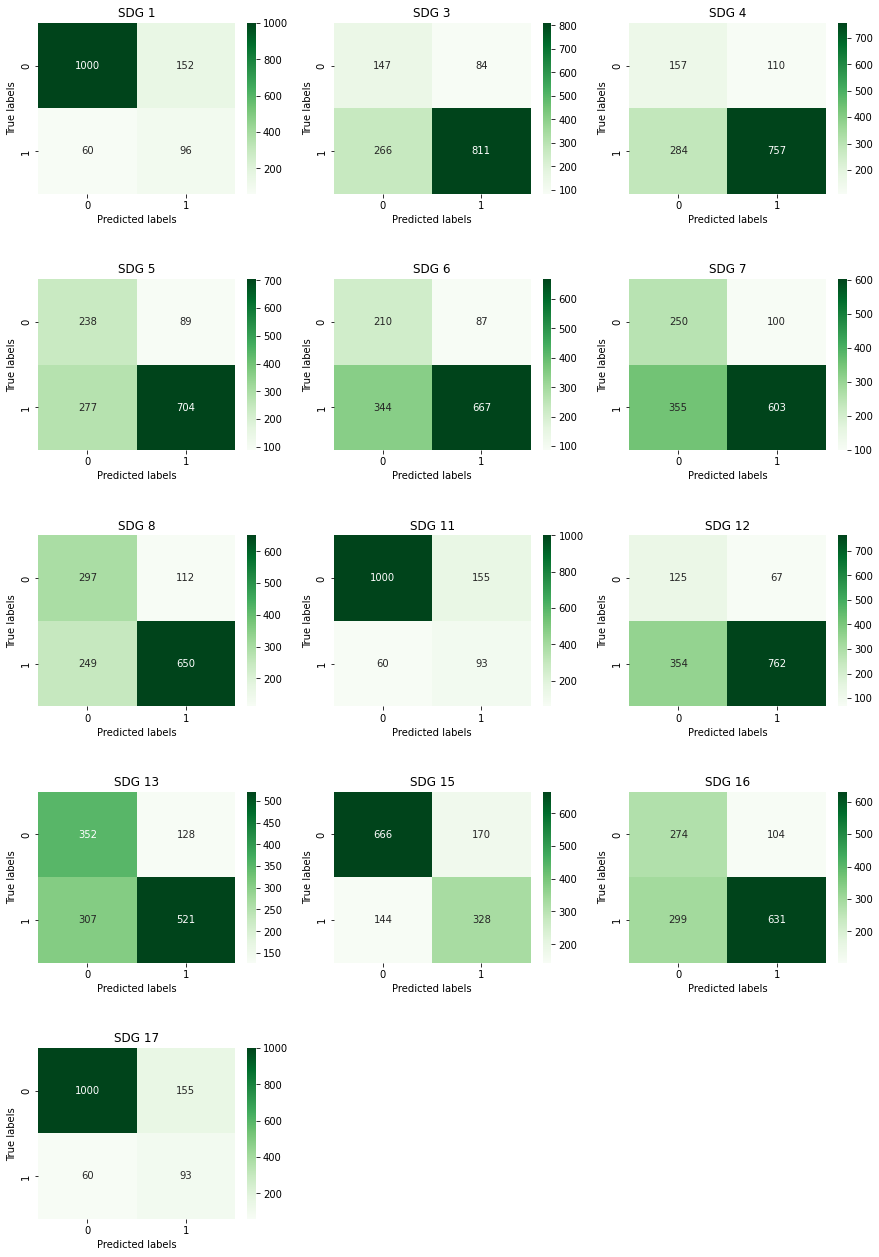

In [17]:
evaluation(grid_lr, outputs_test, Y_test)

### 3.2. Linear SVM

In [18]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_svm = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_svm.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.694, total=   4.2s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.721, total=   8.0s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.719, total= 2.6min
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:  2.7min remaining:  4.0min
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:  4.9min remaining:  1.2min
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:  5.0min finished


[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.708, total=   4.1s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.732, total=   7.8s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.717, total= 2.7min
Best Parameters: {'clf__estimator__C': 1}
Mean cross-validated F1-score of the best estimator: 0.722032125912054


              precision    recall  f1-score   support

           0       0.38      0.68      0.49       156
           1       0.91      0.71      0.80      1077
           2       0.88      0.71      0.79      1041
           3       0.89      0.67      0.76       981
           4       0.90      0.64      0.75      1011
           5       0.86      0.59      0.70       958
           6       0.85      0.71      0.77       899
           7       0.38      0.67      0.48       153
           8       0.93      0.65      0.76      1116
           9       0.80      0.61      0.69       828
          10       0.67      0.68      0.68       472
          11       0.88      0.61      0.72       930
          12       0.38      0.67      0.48       153

   micro avg       0.81      0.66      0.73      9775
   macro avg       0.75      0.66      0.68      9775
weighted avg       0.85      0.66      0.74      9775
 samples avg       0.77      0.63      0.65      9775



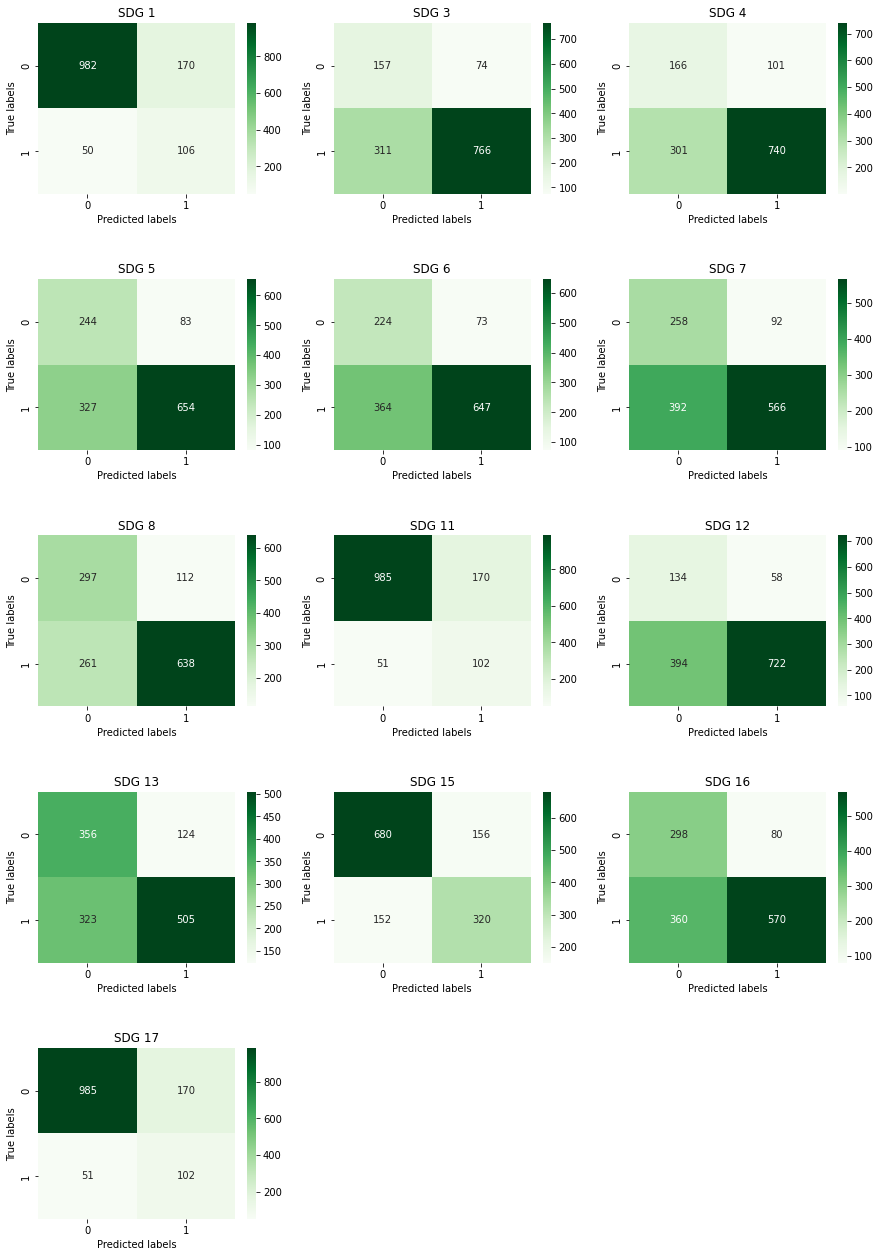

In [19]:
evaluation(grid_svm, outputs_test, Y_test)

### 3.3. Random Forest

In [20]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(RandomForestClassifier(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__n_estimators': [50, 100], # Number of trees in the forest
    'clf__estimator__max_depth': [10, 20, None] # Maximum depth of the tree
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_rf = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_rf.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_rf.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_rf.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Parallel(n_jobs=8)]: Done  26 out of  30 | elapsed:  4.0min remaining:   36.9s
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:  4.1min finished


Best Parameters: {'clf__estimator__max_depth': 10, 'clf__estimator__n_estimators': 100}
Mean cross-validated F1-score of the best estimator: 0.7395059762730872


              precision    recall  f1-score   support

           0       0.59      0.22      0.32       156
           1       0.83      0.99      0.90      1077
           2       0.81      0.99      0.89      1041
           3       0.78      0.96      0.86       981
           4       0.83      0.87      0.85      1011
           5       0.78      0.87      0.83       958
           6       0.74      0.91      0.82       899
           7       0.60      0.24      0.34       153
           8       0.88      0.91      0.89      1116
           9       0.74      0.85      0.79       828
          10       0.75      0.50      0.60       472
          11       0.75      0.91      0.82       930
          12       0.55      0.22      0.31       153

   micro avg       0.79      0.87      0.83      9775
   macro avg       0.74      0.73      0.71      9775
weighted avg       0.78      0.87      0.82      9775
 samples avg       0.79      0.87      0.80      9775



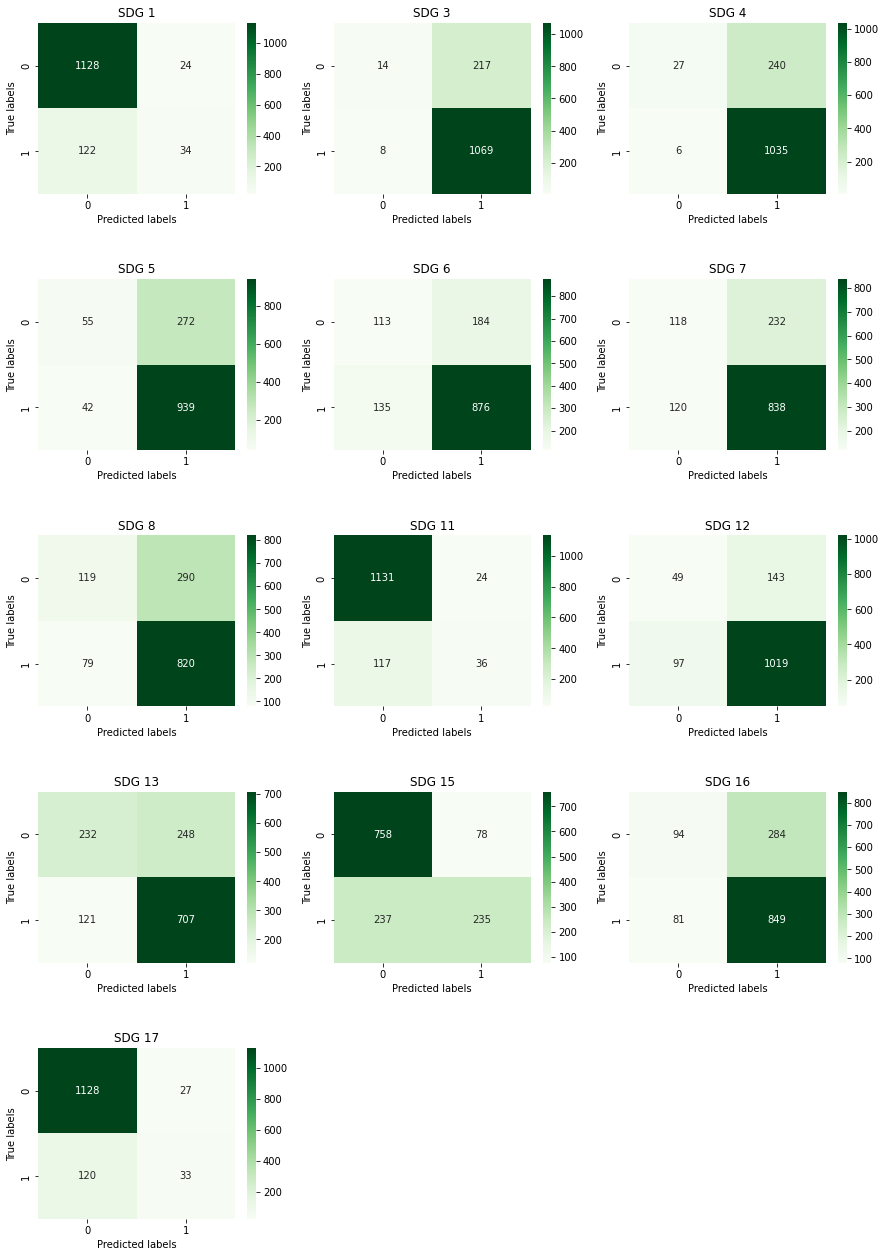

In [21]:
evaluation(grid_rf, outputs_test, Y_test)

## 4. Classification with SMOTE

### 4.1. KNN

In [22]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('clf', KNeighborsClassifier())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__clf__n_neighbors': [5, 15, 25, 55] # Number of neighbors
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_knn = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_knn.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_knn.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_knn.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed:  3.9min remaining:  2.6min
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  5.8min finished


Best Parameters: {'estimator__clf__n_neighbors': 5}
Mean cross-validated F1-score of the best estimator: 0.54581577661665


              precision    recall  f1-score   support

           0       0.15      0.88      0.26       156
           1       0.88      0.48      0.62      1077
           2       0.84      0.44      0.58      1041
           3       0.85      0.45      0.59       981
           4       0.88      0.47      0.61      1011
           5       0.84      0.44      0.57       958
           6       0.80      0.42      0.55       899
           7       0.15      0.86      0.25       153
           8       0.92      0.51      0.66      1116
           9       0.78      0.46      0.58       828
          10       0.42      0.93      0.58       472
          11       0.83      0.45      0.58       930
          12       0.15      0.87      0.26       153

   micro avg       0.58      0.50      0.54      9775
   macro avg       0.65      0.59      0.51      9775
weighted avg       0.80      0.50      0.58      9775
 samples avg       0.52      0.47      0.46      9775



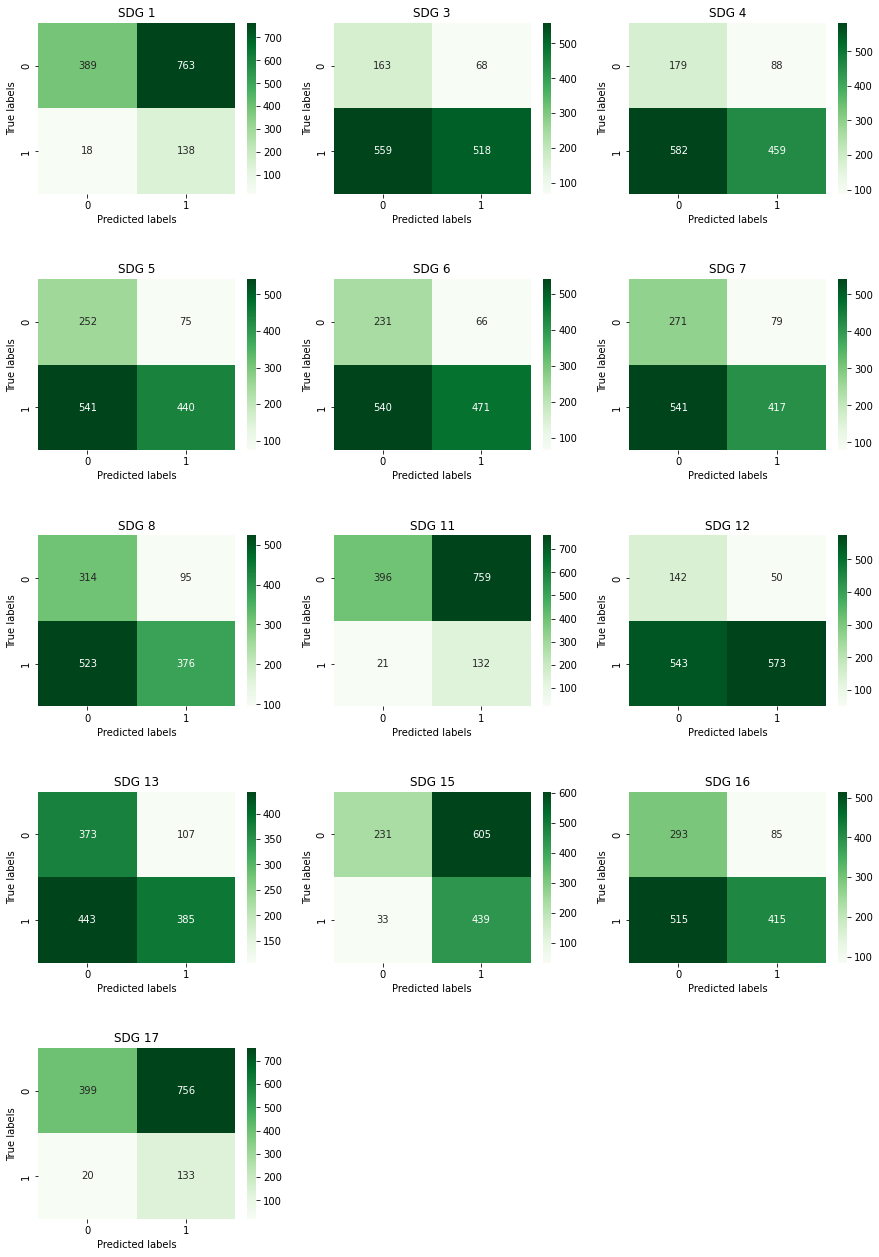

In [23]:
evaluation(grid_knn, outputs_test, Y_test)

### 4.2. Naive Bayes

In [24]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('Normalizing', MinMaxScaler()),
    ('clf', MultinomialNB())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__clf__alpha': [0.01, 0.1, 1] # Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing)
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_nb = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_nb.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_nb.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_nb.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  15 | elapsed:   13.1s remaining:   19.7s
[Parallel(n_jobs=8)]: Done  12 out of  15 | elapsed:   25.9s remaining:    6.5s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:   26.2s finished


Best Parameters: {'estimator__clf__alpha': 0.1}
Mean cross-validated F1-score of the best estimator: 0.6526583848320436


              precision    recall  f1-score   support

           0       0.24      0.62      0.35       156
           1       0.89      0.54      0.67      1077
           2       0.85      0.54      0.66      1041
           3       0.83      0.56      0.67       981
           4       0.86      0.66      0.75      1011
           5       0.80      0.61      0.70       958
           6       0.81      0.66      0.73       899
           7       0.23      0.62      0.34       153
           8       0.90      0.65      0.75      1116
           9       0.78      0.60      0.67       828
          10       0.60      0.60      0.60       472
          11       0.79      0.57      0.66       930
          12       0.24      0.63      0.35       153

   micro avg       0.73      0.60      0.66      9775
   macro avg       0.68      0.61      0.61      9775
weighted avg       0.80      0.60      0.68      9775
 samples avg       0.66      0.58      0.55      9775



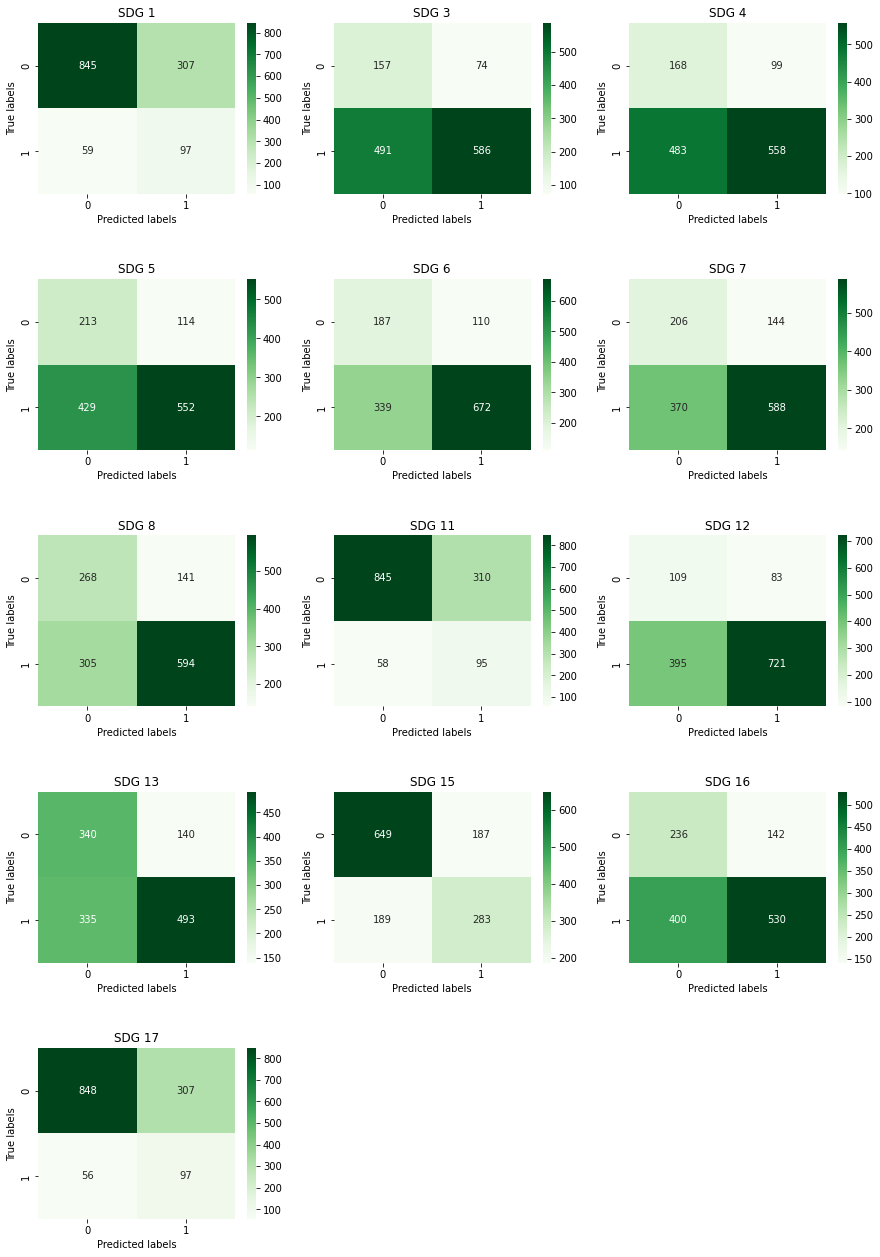

In [25]:
evaluation(grid_nb, outputs_test, Y_test)

### 4.3. XGBoost

In [26]:
np.random.seed(7)

# Pipeline: Resample data with smote and afterwards pass output to classifier
pipeline = Pipeline([
    ('smote', SMOTE()), 
    ('clf', XGBClassifier())
])

# Transform Y into single labels and pass single label data to different copies of pipeline
ovr = OneVsRestClassifier(pipeline)

# Parameter to test in Grid Search
parameters = {
    'estimator__clf__n_estimators': [50, 100], # Number of boosting rounds
    'estimator__clf__max_depth': [5, 10] # Maximum tree depth for base learners
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1) 
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_xgb = GridSearchCV(ovr, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_xgb.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_xgb.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_xgb.best_score_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.713, total=   4.2s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.723, total=  15.5s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.701, total= 2.7min
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.726, total= 2.2min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=50, score=0.733, total=  35.0s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=50, score=0.700, total=  41.8s
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_d

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning

[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.711, total=   4.4s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.730, total=  15.5s
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.720, total= 2.2min
[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.714, total= 2.2min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=50, score=0.735, total=  34.8s
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.742, total= 1.2min
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=50 .
[CV]  clf__estimator__max_

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning

[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.719, total= 2.2min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=50, score=0.732, total=  34.8s
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.735, total= 1.2min
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=100, score=0.703, total= 1.4min
[CV] estimator__clf__n_neighbors=5 ...................................
[CV] ....... estimator__clf__n_neighbors=5, score=0.541, total= 1.9min
[CV] estimator__clf__n_neighbors=25 ..................................
[CV] ...... estimator__clf__n_neighbors=25, score=0.453, total= 1.9min
[CV] estimator__clf__n_neighbors=55 ..................................


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning

[14:40:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:51:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  estimator__clf__max_depth=10, estimator__clf__n_estimators=50, score=0.742, total=135.1min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.700, total=   4.3s
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.722, total=  15.2s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.714, total= 2.7min
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.707, total= 2.3min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.740, total= 1.2min
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=50, score=0.700, total=  41.7s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=50 .
[CV]  clf__estimator__max_

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[15:21:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:31:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  estimator__clf__max_depth=10, estimator__clf__n_estimators=50, score=0.748, total=130.0min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.730, total= 1.2min
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=100, score=0.712, total= 1.4min
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=50 .
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=50, score=0.690, total=  43.0s
[CV] estimator__clf__n_neighbors=5 ...................................
[CV] ....... estimator__clf__n_neighbors=5, score=0.562, total= 1.9min
[CV] estimator__clf__n_neighbors=25 ..................................
[CV] ...... estimator__clf__n_neighbors=25, score=0.463, total= 1.9min
[CV] estimator__clf__n_neighbors=55 ..................................
[CV] ...... estimator__clf__n_neighbors=55, score=0.401, total= 1.9min
[CV] estimator__clf__alpha=0.1 ......................................

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[CV] clf__estimator__C=1 .............................................
[CV] ................. clf__estimator__C=1, score=0.723, total=   8.1s
[CV] clf__estimator__C=0.1 ...........................................
[CV] ............... clf__estimator__C=0.1, score=0.707, total= 2.7min
[CV] clf__estimator__C=10 ............................................
[CV] ................ clf__estimator__C=10, score=0.712, total= 2.3min
[CV] clf__estimator__max_depth=10, clf__estimator__n_estimators=100 ..
[CV]  clf__estimator__max_depth=10, clf__estimator__n_estimators=100, score=0.750, total= 1.2min
[CV] clf__estimator__max_depth=20, clf__estimator__n_estimators=50 ...
[CV]  clf__estimator__max_depth=20, clf__estimator__n_estimators=50, score=0.699, total=  41.9s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=50 .
[CV]  clf__estimator__max_depth=None, clf__estimator__n_estimators=50, score=0.678, total=  43.3s
[CV] clf__estimator__max_depth=None, clf__estimator__n_estimators=100 

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[CV] estimator__clf__max_depth=5, estimator__clf__n_estimators=100 ...
[12:43:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:50:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:04:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'l

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[CV]  estimator__clf__max_depth=5, estimator__clf__n_estimators=100, score=0.754, total=90.7min
[CV] estimator__clf__max_depth=10, estimator__clf__n_estimators=100 ..
[14:14:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:25:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:38:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:53:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the de

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[16:40:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:41:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:42:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:43:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[CV] estimator__clf__max_depth=10, estimator__clf__n_estimators=50 ...
[12:44:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:52:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:13:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'l

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/jbaumert/miniconda3/envs/ma-jo

[16:45:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:46:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:47:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:48:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

              precision    recall  f1-score   support

           0       0.56      0.34      0.42       156
           1       0.86      0.90      0.88      1077
           2       0.82      0.92      0.87      1041
           3       0.82      0.87      0.84       981
           4       0.84      0.83      0.83      1011
           5       0.80      0.79      0.79       958
           6       0.79      0.82      0.80       899
           7       0.57      0.36      0.44       153
           8       0.89      0.89      0.89      1116
           9       0.77      0.74      0.75       828
          10       0.76      0.61      0.67       472
          11       0.79      0.83      0.81       930
          12       0.57      0.36      0.44       153

   micro avg       0.81      0.81      0.81      9775
   macro avg       0.76      0.71      0.73      9775
weighted avg       0.81      0.81      0.81      9775
 samples avg       0.80      0.80      0.78      9775



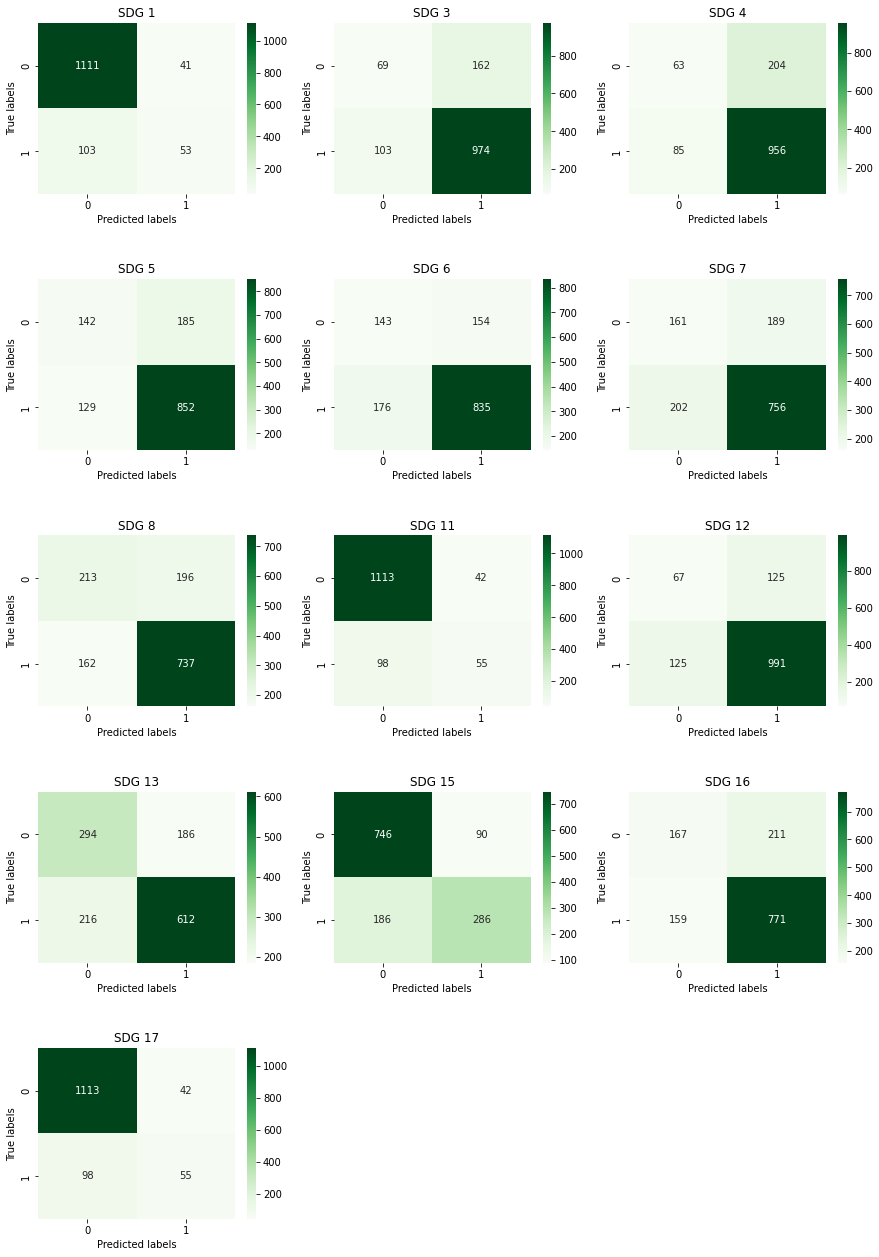

In [27]:
evaluation(grid_xgb, outputs_test, Y_test)